### Import required modules

In [881]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt  
plt.style.use('seaborn-whitegrid')

### Load and preprocess the data

In [882]:
### Load gene_acc to gene_name data file
acc2genename_df = pd.read_csv('./data/KPT-DMSO-NUC-CYTO.csv',
                             index_col = 0,
                             usecols=[0,1,8,9])

# Replace "Repeat" in column exon_count with NaN
acc2genename_df['exon_count'] = acc2genename_df['exon_count'].replace(["Repeat"], None)
acc2genename_df['exon_count'] = acc2genename_df['exon_count'].astype(int)


In [883]:
### Load RNAseq TPM data
tpm_df = pd.read_csv('./data/TPM_DMSO-KPT_nuc_cyto.csv', 
                     index_col=0, 
                     usecols=[0,2,3,4,8,9,10])


In [884]:
### Merge tpm_df + acc2genename_df
tpm_df = pd.concat([tpm_df,acc2genename_df], axis=1)


In [885]:
tpm_df['tpm_cyt'] = tpm_df[['cytoplasmic_dmso_3hrs_1','cytoplasmic_dmso_3hrs_2','cytoplasmic_dmso_3hrs_3']].mean(axis=1)
tpm_df['tpm_nuc']  = tpm_df[['nuclear_dmso_3hrs_1','nuclear_dmso_3hrs_2','nuclear_dmso_3hrs_3']].mean(axis=1)
tpm_df = tpm_df.drop(columns=['cytoplasmic_dmso_3hrs_1',
                     'cytoplasmic_dmso_3hrs_2',
                     'cytoplasmic_dmso_3hrs_3',
                     'nuclear_dmso_3hrs_1',
                     'nuclear_dmso_3hrs_2',
                     'nuclear_dmso_3hrs_3'])


In [886]:
# Add label "both" to flag genes detected in both nuclear and cyto fractions
def set_flag (row):
    cutoff = 1
    if (row.tpm_cyt >= cutoff) & (row.tpm_nuc >= cutoff):
        return 'both'
    elif row.tpm_cyt >= cutoff:
        return 'cyto_target'
    elif row.tpm_nuc >= cutoff:
        return 'nuc_target'
    else:
        return 'no'
        
#tpm_df.drop(columns='flag')
        
tpm_df['target_all'] = tpm_df.apply(set_flag, axis=1)
#tpm_df[(tpm_df['tpm_cyt'] > 0) & (tpm_df['tpm_nuc'] > 0)]['target'] = 'both'



In [887]:
# Add exon bins
bins = [0,1,5,10,15,20,30,1000]
labels = ['1','2-5','6-10','11-15','16-20','21-30','>30']
tpm_df['exon_group'] = pd.cut(tpm_df['exon_count'], bins=bins, labels=labels)



In [888]:
### Load parclip data
parclip_df = pd.read_excel('./data/103_Nuc_cyto_new.xlsx', index_col=1)


In [889]:
# Remove unnecessary columns
parclip_df = parclip_df.drop(columns=['Unnamed: 0', 'exon_count.x.x',
                            'gene_type.x.x', 'exon_count.y.x', 
                            'gene_type.y.x', 'exon_group.x',
                            'exon_count.x.y','gene_type.x.y']
               )

In [890]:
# Replace '-' with NAs
parclip_df = parclip_df.replace(to_replace='-', value=np.nan)

# Drop rows with all missing values
keep_index = parclip_df.loc[:,parclip_df.columns.str.contains(pat='_normal')] \
                .dropna(axis=0, how='all') \
                .index
parclip_df = parclip_df.loc[keep_index]



In [891]:
# Normalize column names
new_col_names = ['XL_all_nuc_norm', 'XL_exon_nuc_norm',
       'XL_coding_nuc_norm', 'XL_3utr_nuc_norm', '3utr_nuc_target',
       'nuc_target', 'XL_all_cyt_norm', 'XL_5utr_cyt_norm',
       'XL_intron_cyt_norm', 'XL_exon_cyt_norm', 'XL_coding_cyt_norm',
       'XL_3utr_cyt_norm', 'exon_count', 'gene_type',
       'exon_group', '3utr_cyt_target', 'cyt_target', '3utr_both_target',
       'target_all']
parclip_df.columns = new_col_names

# convert exon_counts to int
parclip_df.exon_count = parclip_df.exon_count.astype(int)


In [892]:
# Replace evon_group names
parclip_df['exon_group'] = pd.cut(parclip_df['exon_count'], bins=bins, labels=labels)

# Replace target flags to match tpm_df flags
def set_flag_pc (row):
    cutoff = 1
    if (row.nuc_target == 'nuc_target') & (row.cyt_target == 'cyto_target'):
        return 'both'
    elif row.cyt_target == 'cyto_target':
        return 'cyto_target'
    elif row.nuc_target == 'nuc_target':
        return 'nuc_target'
    else:
        return 'no'
        
#tpm_df.drop(columns='flag')
        
parclip_df['target_all'] = parclip_df.apply(set_flag_pc, axis=1)

### Filtering protein_coding

In [893]:
## Keep only protein_coding genes
tpm_df = tpm_df.query('broader_type == "protein_coding"')
parclip_df = parclip_df.query('gene_type == "protein_coding"')

#### Create plots for gene counts

In [894]:
# Prepare gene counts
pc_nuc_counts_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_nuc_norm.count()
pc_cyt_counts_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_cyt_norm.count()

rnaseq_nuc_counts_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_nuc.count()
rnaseq_cyt_counts_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_cyt.count()

norm_counts_df = pd.concat([pc_nuc_counts_s,pc_cyt_counts_s,rnaseq_nuc_counts_s,rnaseq_cyt_counts_s], axis=1)
norm_counts_df.columns = ['parclip_nuc','parclip_cyt','rnaseq_nuc','rnaseq_cyt']

In [895]:
print(tpm_df.tpm_cyt.count())
print(tpm_df.tpm_nuc.count())

14529
14529


1- Gene counts vs exon counts (nuc)

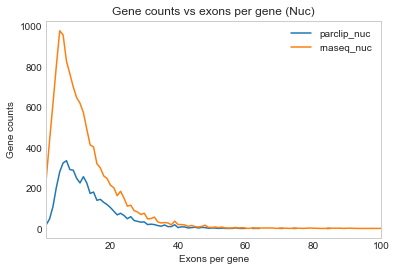

In [896]:
# Gene counts vs exon counts (NUC)
norm_counts_nuc_p = norm_counts_df.plot(y=['parclip_nuc','rnaseq_nuc'], 
                title='Gene counts vs exons per gene (Nuc)',
                xlabel='Exons per gene',
                ylabel='Gene counts',
                grid=False,
                xlim=(1,100))
fig = norm_counts_nuc_p.get_figure()
fig.savefig('./gene_counts_exons_per_gene_NUC.pdf')

2- Gene counts vs exon counts (cyt)

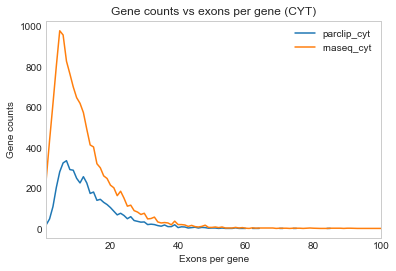

In [897]:
# Gene counts vs exon counts (CYT)
norm_counts_cyt_p = norm_counts_df.plot(y=['parclip_cyt','rnaseq_cyt'], 
                title='Gene counts vs exons per gene (CYT)',
                xlabel='Exons per gene',
                ylabel='Gene counts',
                grid=False,
                xlim=(1,100))
fig = norm_counts_cyt_p.get_figure()
fig.savefig('./gene_counts_exons_per_gene_CYT.pdf')

Calculate relative gene counts

In [898]:
# Calculate relative counts
norm_counts_df['parclip_nuc_perc'] = norm_counts_df.parclip_nuc * 100 / norm_counts_df.parclip_nuc.sum()
norm_counts_df['parclip_cyt_perc'] = norm_counts_df.parclip_cyt * 100 / norm_counts_df.parclip_cyt.sum()

norm_counts_df['rnaseq_nuc_perc'] = norm_counts_df.rnaseq_nuc * 100 / norm_counts_df.rnaseq_nuc.sum()
norm_counts_df['rnaseq_cyt_perc'] = norm_counts_df.rnaseq_cyt * 100 / norm_counts_df.rnaseq_cyt.sum()


3- Relative gene counts vs exon counts (nuc)

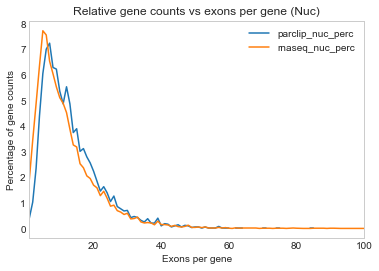

In [899]:
# Relative gene counts vs exon counts (NUC)
norm_counts_p = norm_counts_df.plot(y=['parclip_nuc_perc','rnaseq_nuc_perc'], 
                title='Relative gene counts vs exons per gene (Nuc)',
                xlabel='Exons per gene',
                ylabel='Percentage of gene counts',
                grid=False, 
                xlim=(1,100))
fig = norm_counts_p.get_figure()
fig.savefig('./percentage_gene_counts_exons_per_gene_NUC.pdf')

4- Relative gene counts vs exon counts (cyt)

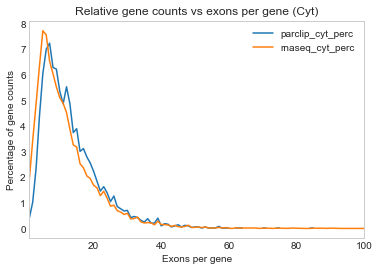

In [900]:
# Relative gene counts vs exon counts (CYT)
norm_counts_p = norm_counts_df.plot(y=['parclip_cyt_perc','rnaseq_cyt_perc'], 
                title='Relative gene counts vs exons per gene (Cyt)',
                xlabel='Exons per gene',
                ylabel='Percentage of gene counts',
                grid=False, 
                xlim=(1,100))
fig = norm_counts_p.get_figure()
fig.savefig('./percentage_gene_counts_exons_per_gene_CYT.pdf')

## Creat plots for read counts
Calculate read sums

In [901]:
# Normalized read counts
pc_nuc_sum_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_nuc_norm.sum()
pc_cyt_sum_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_cyt_norm.sum()

rnaseq_nuc_sum_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_nuc.sum()
rnaseq_cyt_sum_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_cyt.sum()

norm_sum_df = pd.concat([pc_nuc_sum_s,pc_cyt_sum_s,rnaseq_nuc_sum_s,rnaseq_cyt_sum_s], axis=1)
norm_sum_df.columns = ['parclip_nuc','parclip_cyt','rnaseq_nuc','rnaseq_cyt']


1- Read counts vs exon counts (nuc)

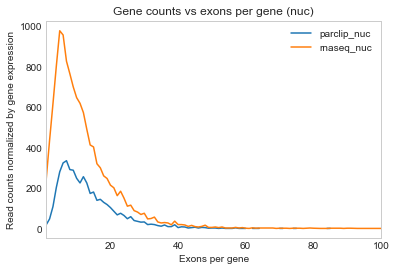

In [902]:
norm_sum_p = norm_counts_df.plot(y=['parclip_nuc','rnaseq_nuc'], 
                title='Gene counts vs exons per gene (nuc)',
                xlabel='Exons per gene',
                ylabel='Read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./norm_read_counts_vs_exons_per_gene_NUC.pdf')

2- Read counts vs exon counts (cyt)

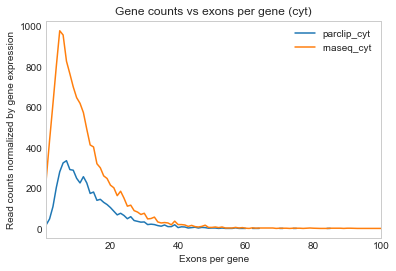

In [903]:
norm_sum_p = norm_counts_df.plot(y=['parclip_cyt','rnaseq_cyt'], 
                title='Gene counts vs exons per gene (cyt)',
                xlabel='Exons per gene',
                ylabel='Read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./norm_read_counts_vs_exons_per_gene_CYT.pdf')

Calculate relative read counts

In [904]:
norm_sum_df['parclip_nuc_perc'] = norm_sum_df.parclip_nuc * 100 / norm_sum_df.parclip_nuc.sum()
norm_sum_df['parclip_cyt_perc'] = norm_sum_df.parclip_cyt * 100 / norm_sum_df.parclip_cyt.sum()

norm_sum_df['rnaseq_nuc_perc'] = norm_sum_df.rnaseq_nuc * 100 / norm_sum_df.rnaseq_nuc.sum()
norm_sum_df['rnaseq_cyt_perc'] = norm_sum_df.rnaseq_cyt * 100 / norm_sum_df.rnaseq_cyt.sum()

norm_sum_df

,parclip_nuc,parclip_cyt,rnaseq_nuc,rnaseq_cyt,parclip_nuc_perc,parclip_cyt_perc,rnaseq_nuc_perc,rnaseq_cyt_perc
exon_count,,,,,,,,
1,995.360597,10029.714522,45168.718032,81171.247584,0.169480,0.330839,6.293629,9.715600
2,2168.401029,17585.618334,36053.570374,41217.785984,0.369213,0.580076,5.023560,4.933465
3,10362.305433,67764.996940,28829.660605,42259.107296,1.764386,2.235285,4.017010,5.058104
4,28017.540844,158904.573234,37653.209135,54331.478212,4.770537,5.241600,5.246448,6.503077
5,29293.433915,239987.694702,46552.583203,62987.851838,4.987783,7.916195,6.486451,7.539182
...,...,...,...,...,...,...,...,...
105,NaN,NaN,82.627631,28.999373,NaN,NaN,0.011513,0.003471
106,85.950370,62.503217,125.653909,113.594153,0.014635,0.002062,0.017508,0.013596
116,18.576115,175.925562,86.931826,18.085532,0.003163,0.005803,0.012113,0.002165


3- Relative read counts vs exon counts (nuc)

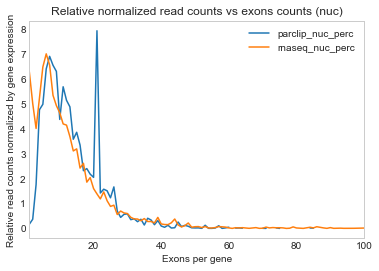

In [905]:
norm_sum_p = norm_sum_df.plot(y=['parclip_nuc_perc','rnaseq_nuc_perc'], 
                title='Relative normalized read counts vs exons counts (nuc)',
                xlabel='Exons per gene',
                ylabel='Relative read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./relative_norm_read_counts_vs_exons_per_gene_NUC.pdf')

4- Relative read counts vs exon counts (cyt)

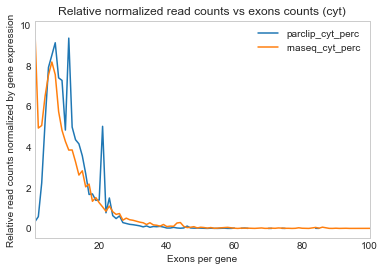

In [906]:
norm_sum_p = norm_sum_df.plot(y=['parclip_cyt_perc','rnaseq_cyt_perc'], 
                title='Relative normalized read counts vs exons counts (cyt)',
                xlabel='Exons per gene',
                ylabel='Relative read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./relative_norm_read_counts_vs_exons_per_gene_CYT.pdf')

## Piechart plots gene counts
1- Parclip nuclear

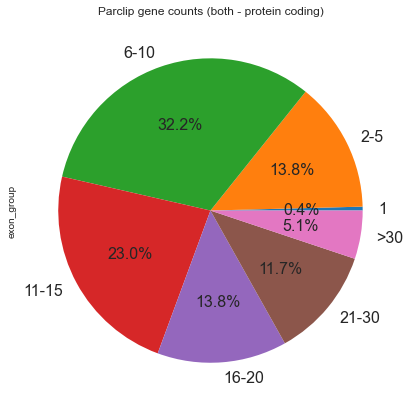

In [907]:
pc = parclip_df.query('target_all=="both"').groupby("exon_group")['exon_group']  \
    .count() \
    / len(parclip_df.query('target_all=="both"'))

pc_pie_p = pc.plot.pie(title='Parclip gene counts (both - protein coding)', normalize=False,
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = pc_pie_p.get_figure()
fig.savefig('./piechart_gene_counts_vs_exons_per_gene_parclip_BOTH.pdf')


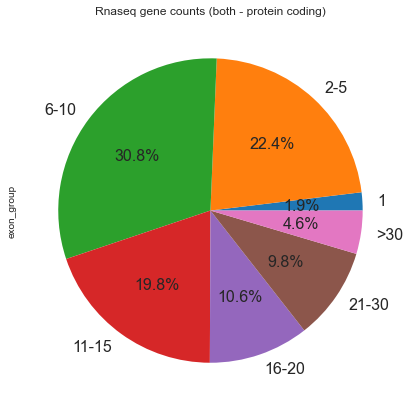

In [908]:
rnaseq = tpm_df.query('target_all=="both"').groupby("exon_group")['exon_group'] \
    .count() \
    / len(tpm_df.query('target_all=="both"'))

rnaseq_pie_p = rnaseq.plot.pie(title='Rnaseq gene counts (both - protein coding)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = rnaseq_pie_p.get_figure()
fig.savefig('./piechart_gene_counts_vs_exons_per_gene_rnaseq_BOTH.pdf')


### Piechar plots of normalized read counts (nuc)

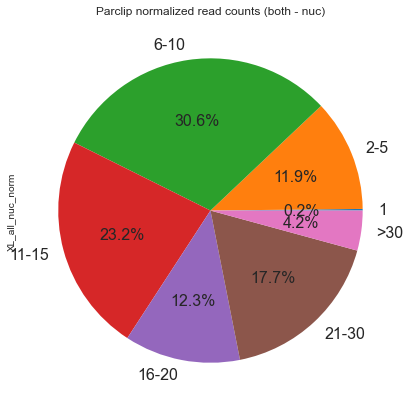

In [909]:
pc_rel = parclip_df.query('target_all=="both"').groupby("exon_group")['XL_all_nuc_norm']  \
    .sum() / parclip_df.query('target_all=="both"')['XL_all_nuc_norm'].count()

pc_rel_pie_p = pc_rel.plot.pie(title='Parclip normalized read counts (both - nuc)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_pc_rel = pc_rel_pie_p.get_figure()
fig_pc_rel.savefig('./piechart_read_counts_vs_exons_per_gene_parclip_range_NUC_both.pdf')



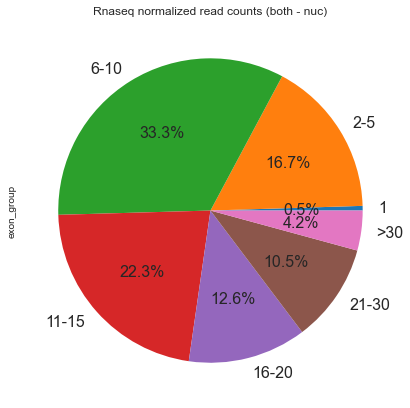

In [910]:
rnaseq_rel = tpm_df.query('target_all=="both"').groupby("exon_group")['tpm_nuc']  \
    .sum() / tpm_df.query('target_all=="both"')['tpm_nuc'].count()

rnaseq_rel_pie_p = hekc.plot.pie(title='Rnaseq normalized read counts (both - nuc)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_rnaseq_rel = rnaseq_rel_pie_p.get_figure()
fig_rnaseq_rel.savefig('./piechart_read_counts_vs_exons_per_gene_rnaseq_range_NUC_both.pdf')

### Piechar plots of normalized read counts (cyt)

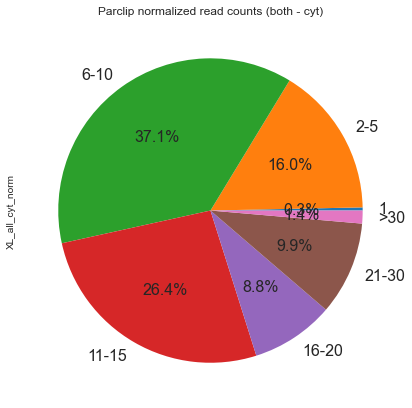

In [911]:
pc_rel = parclip_df.query('target_all=="both"').groupby("exon_group")['XL_all_cyt_norm']  \
    .sum() / parclip_df.query('target_all=="both"')['XL_all_cyt_norm'].count()

pc_rel_pie_p = pc_rel.plot.pie(title='Parclip normalized read counts (both - cyt)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_pc_rel = pc_rel_pie_p.get_figure()
fig_pc_rel.savefig('./piechart_read_counts_vs_exons_per_gene_parclip_range_CYT_both.pdf')



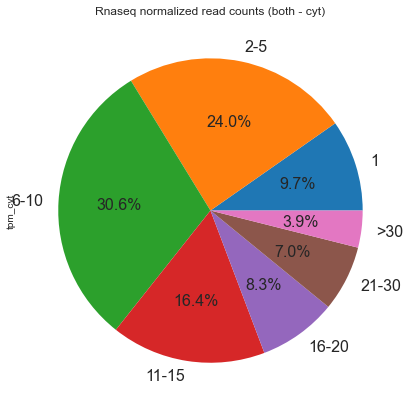

In [912]:
rnaseq_rel = tpm_df.query('target_all=="both"').groupby("exon_group")['tpm_cyt']  \
    .sum() / tpm_df.query('target_all=="both"')['tpm_cyt'].count()

rnaseq_rel_pie_p = rnaseq_rel.plot.pie(title='Rnaseq normalized read counts (both - cyt)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_rnaseq_rel = rnaseq_rel_pie_p.get_figure()
fig_rnaseq_rel.savefig('./piechart_read_counts_vs_exons_per_gene_rnaseq_range_CYT_both.pdf')

